# Entropy estimates in the isochrone potential

Here we estimate the entropy of samples in the isochrone potential, and plot it as a function of time while integrating orbits for these samples - see the Introduction for the general expressions.

We do that both for self-consistent and non-stationary samples. In the self-consistent case, we compare the estimates with the true entropy calculated with analytical expressions for the DF and density of states of the isochrone model. We use the [agama](https://github.com/GalacticDynamics-Oxford/Agama) package for the orbit integration, sampling from a DF and action calculations, but you may prefer other packages, such as [gala](http://gala.adrian.pw/en/latest/) or [galpy](https://www.galpy.org/). Of course, the entropy estimate itself does not depend on how the data were generated.

We estimate the entropy of the DF $f(\vec{w})$, where $\vec{w} = (\vec{r}, \vec{v})$ are the 6D phase-space coordinates:

$S \equiv -\int f(\vec{w})\ln\left(\frac{f}{\mu}\right)\, \mathrm{d}^6\vec{w} = -\int f'(\vec{w}')\ln f'\, \mathrm{d}^6\vec{w}'$,

where $\mu = |\Sigma|^{-1}$, $|\Sigma|$ is the product of the dispersions in each of the coordinates, and $f'(\vec{w}') = |\Sigma|f(\vec{w})$ is the DF of the coordinates normalized by their dispersions - see the Introduction.

Assuming that $f(\vec{w})$ is a function of integrals $\vec{I}$ only, e.g. $f=f(E)$, $f = f(E,L)$, or $f = f(\vec{J})$ (all valid assumptions for the self-consistent sample of the isochrone model), where $E$ is energy, $L$ is angular momentum, and $\vec{J}$ three actions, with the appropriate change of variables we obtain in general

$S_{\vec{I}} = -\int F(\vec{I}) \ln\left( \frac{|\Sigma|F(\vec{I})}{g(\vec{I})}\right)\, \mathrm{d}\vec{I}$,

where $g(\vec{I})$ is the density of states -- see Appendix A of [Beraldo e Silva et al (2024)](https://arxiv.org/abs/2407.07947) for details. Note that $S_{\vec{I}}$ is not "the entropy in the space of integrals" but, instead,  $S_{\vec{I}}$ is still the entropy of the 6D DF $f$, i.e. $S_{\vec{I}} = S(f)$, for cases where one can assume that the DF is $f = f(\vec{I})$, which is true for stationary samples (Jeans' theorem).

The codes are essentially the same used to produce Figs. 2 and 4 in Beraldo e Silva+ 2024. For the paper, we generated samples as large as $N=10^8$, but below we generate only up to $N=10^6$, and one can decrease the size, or the number of time-steps where the entropy is estimated if this is taking too long (it takes $\sim 10-15$ minutes for $N=10^6$ evaluated in 100 time-steps in my laptop).

We start importing the relevant modules and setting some parameters for prettier plots. We use agama to generate samples, integrate orbits and calculate actions, but any other libray could be used instead.

In [1]:
# Import modules
import numpy as np
from scipy import integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

import agama
import tropygal

from matplotlib.ticker import ScalarFormatter, NullFormatter

params = {'axes.labelsize': 24, 'xtick.labelsize': 20, 
          'xtick.direction': 'in', 'xtick.major.size': 8.0,
          'xtick.bottom': 1, 'xtick.top': 1, 'ytick.labelsize': 20,
          'ytick.direction': 'in','ytick.major.size': 8.0,'ytick.left': 1,
          'ytick.right': 1,'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 32, 'font.family': 'serif'}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 60
columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Set constants

In [2]:
# Mass and scale radius for the isochrone potential:
M = 1.
b = 1.

# Making sure we have G = 1:
agama.setUnits()
G = agama.G
print ('G:',G)

n_steps = 100 # number of time steps in the orbit integration (and at which the entropy is estimated)

G: 1.0


## Define functions for true entropy of self-consistent sample

In [3]:
# Analytical expressions for DF of self-consistent isochrone model:
def F_E(E, M, b, G):
    f_E = tropygal.DF_Isochrone(E, M, b, G=G)
    g_E = tropygal.g_Isochrone(E, M, b, G=G)

    return f_E*g_E # F(E) = f(E)g(E)
#----------------- 
def S_E_true_integrand(E, M, b, mu, G):
    # Integrand for calculation of true entropy
    # F(E) = f(E) * g(E)
    # it returns F(E) * ln(F(E)/mu(E)), and mu(E) = |Sigma|^(-1) * g(E)
    f_E = tropygal.DF_Isochrone(E, M, b, G)

    return F_E(E, M, b, G)*np.log(f_E/mu) # externally, mu is set to |Sigma|^(-1)

## Check normalization of F(E)

In [4]:
E_I_min = -M*G/(2.*b) # Minimum of potential
E_I_max = -1e-7

norm = integrate.quad(F_E, a=E_I_min, b=E_I_max, args=(M, b, G))[0]
print ('norm of F(E):', norm)

norm of F(E): 0.9999996800000946


## Entropy estimates

In [5]:
# Set params and initialize arrays:

n_orbs = [int(N) for N in [1e+4, 1e+5, 1e+6]]
# For the plots:
N_label = ['10k', '100k', '1m']
N_label_plot = [r'$10^4$', r'$10^5$', r'$10^6$']
N_colors = ['black', 'red', 'blue']

S_E_true = np.full(len(n_orbs), np.nan)

Tcirc = np.full(len(n_orbs), np.nan) # mean circular period for each sample
t = np.full((len(n_orbs), n_steps), np.nan) # time in the orbit integration

S_6D = np.full((len(n_orbs), n_steps), np.nan) # Entropy evaluated in 6D
# Entropies assuming the DF is f = f(E), or f = f(E,L), or f = f(J)
# These should be the same as S_6D if f = f(E), or f = f(E,L), or f = f(J)
S_E = np.full(len(n_orbs), np.nan)
S_EL = np.full(len(n_orbs), np.nan)
S_J = np.full(len(n_orbs), np.nan)

# Potential and DF (using agama)
# This creates an isochrone potential of a given mass and scale radius:
isoc_pot = agama.Potential(type='Isochrone', mass=M, scaleRadius=b)
# This creates a DF of a self-consistent sample:
isoc_df = agama.DistributionFunction(type='QuasiSpherical', potential=isoc_pot, density=isoc_pot)
# This creates an action finder for the given potential:
actF = agama.ActionFinder(isoc_pot)

In [6]:
# Generate samples, integrate and estimate entropy:
for i in range(len(n_orbs)):
    print ('-------------------------')
    dim = 6
    print ('Generating sample...')
    N = n_orbs[i]
    # Generate self-consistent sample of the isochrone potential.
    # Some care is needed here, since it's important to make sure the initial sample is really stationary in the potential.
    # A constant entropy for this sample indicates that it is truly stationary - see plot below with the time evolution.
    # If using agama, see option #define DISABLE_QRNG in src/math_sample.cpp, or in Makefile.local, which might need to be set before compilation
    data,_ = agama.GalaxyModel(isoc_pot, isoc_df).sample(N)
    # data, _ = isoc_pot.sample(N, potential=isoc_pot) 
    #------------------------------ 
    sigma_6D_0 = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in data.T])
    mu = 1./np.prod(sigma_6D_0)

    # In principle, S_true shouldn't depend on the sample size, and could be calculated outside of this loop,
    # But we are using mu = |Sigma|^(-1) to normalize the coordinates, with the exact |Sigma| changing for different samples,
    # but |Sigma| converges for large samples
    S_E_true[i] = -integrate.quad(S_E_true_integrand, a=E_I_min, b=E_I_max, args=(M, b, mu, G))[0]
    print ('S_E (true):', np.round(S_E_true[i], 5))
    #------------------------------ 
    # Estimate S_6D (at t=0; estimates over time are done below):
    S_6D[i, 0] = tropygal.entropy(data/sigma_6D_0)
    print ('S_6D estimated:', np.round(S_6D[i, 0], 5))
    #------------------
    # Estimate S_E, i.e. assuming f = f(E):
    
    x  = data[:,0]; y  = data[:,1]; z  = data[:,2]
    vx = data[:,3]; vy = data[:,4]; vz = data[:,5]
    
    v2 = vx**2 + vy**2 + vz**2
    pos = np.column_stack((x, y, z))
    E = isoc_pot.potential(pos) + 0.5*v2
    sigma_E = 0.5*(np.percentile(E, 84) - np.percentile(E, 16))
    
    g_E = tropygal.g_Isochrone(E, M, b=b, G=G)
    # It's convenient to normalize coordinates in the space where the entropy is estimated,
    # but we want to stick to the entropy definition we used before, so the normalized coordinates are passed as the data,
    # and mu takes care of the appropriate factors in the change of variables for the integral defining the entropy to be the same.
    S_E[i] = tropygal.entropy(E/sigma_E, mu= g_E*np.abs(sigma_E)/np.abs(np.prod(sigma_6D_0)))
    print ('S_E estimated:', np.round(S_E[i], 5))
    #-------------------------
    # Estimate S_EL, i.e. assuming f = f(E,L):
    
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2)
    EL = np.column_stack((E, L))
    sigma_L = 0.5*(np.percentile(L, 84) - np.percentile(L, 16))
    sigma_EL = np.array([sigma_E, sigma_L])

    g_EL = tropygal.gEL_Isochrone(E, L, M, G=G)
    S_EL[i] = tropygal.entropy(EL/sigma_EL, mu= g_EL*np.prod(sigma_EL)/np.prod(sigma_6D_0))
    print ('S_EL estimated:', np.round(S_EL[i], 5))
    #------------------------------ 
    # Estimate S_J, i.e. assuming f = f(J):

    J = actF(data, actions=True, frequencies=False, angles=False)
    sigma_J = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in J.T])
    S_J[i] = tropygal.entropy(J/sigma_J, mu= ((2.*np.pi)**3)*np.prod(sigma_J)/np.prod(sigma_6D_0))
    print ('S_J estimated:', np.round(S_J[i],5))
    #------------------------------ 
    # Estimate S_6D at different times

    # define integration time (same for all orbits):
    Tcirc[i] = np.median(isoc_pot.Tcirc(data))
    int_time = 50*Tcirc[i]
    delta_t = int_time/n_steps
    t[i, 0] = 0
    
    for j in range(1, n_steps):
        # Integrate orbits for one time-step:
        orbs = agama.orbit(potential=isoc_pot, ic = data, time = delta_t, trajsize =1, verbose=False)

        t[i, j] = t[i, j-1] + delta_t
        all_coords = np.vstack(orbs[:,1]).reshape(len(x), 1, dim)
        # update data with new coords:
        data = all_coords[:,-1,:]
        sigma_6D = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in data.T])
        # Here we re-normalize again at every time-step (to facilitate the estimate), 
        # "compensating" for that in the mu factor, i.e. making an appropriate change of variables every time-step:
        S_6D[i,j] = tropygal.entropy(data/sigma_6D, mu=np.prod(sigma_6D)/np.prod(sigma_6D_0))
        if (j%10==0):
            print ('j:', j, 'S_6D estimated:', np.round(S_6D[i, j], 5))

-------------------------
Generating sample...
S_E (true): 9.23354
S_6D estimated: 9.60372
S_E estimated: 9.25726
S_EL estimated: 9.27627
S_J estimated: 9.28593
j: 10 S_6D estimated: 9.5854
j: 20 S_6D estimated: 9.62477
j: 30 S_6D estimated: 9.66206
j: 40 S_6D estimated: 9.58258
j: 50 S_6D estimated: 9.62601
j: 60 S_6D estimated: 9.63817
j: 70 S_6D estimated: 9.62296
j: 80 S_6D estimated: 9.61056
j: 90 S_6D estimated: 9.629
-------------------------
Generating sample...
S_E (true): 9.25089
S_6D estimated: 9.50836
S_E estimated: 9.25667
S_EL estimated: 9.26148
S_J estimated: 9.26284
j: 10 S_6D estimated: 9.5107
j: 20 S_6D estimated: 9.51411
j: 30 S_6D estimated: 9.50935
j: 40 S_6D estimated: 9.50449
j: 50 S_6D estimated: 9.50255
j: 60 S_6D estimated: 9.50929
j: 70 S_6D estimated: 9.50681
j: 80 S_6D estimated: 9.50488
j: 90 S_6D estimated: 9.51764
-------------------------
Generating sample...
S_E (true): 9.25154
S_6D estimated: 9.42569
S_E estimated: 9.25121
S_EL estimated: 9.25654
S_J 

## Plot

In [7]:
# Calc errors
err_S_6D = np.zeros(len(n_orbs))
err_S_E = np.zeros(len(n_orbs))
err_S_EL = np.zeros(len(n_orbs))
err_S_J = np.zeros(len(n_orbs))
#-------------------
for i in range(len(n_orbs)):
    # Calculate error with the time-average of S_6D, in respect to the true value:
    err_S_6D[i] = (np.mean(S_6D[i]) - S_E_true[-1])/S_E_true[-1]
    
    err_S_E[i] = (S_E[i] - S_E_true[-1])/S_E_true[-1]
    err_S_EL[i] = (S_EL[i] - S_E_true[-1])/S_E_true[-1]
    err_S_J[i] = (S_J[i] - S_E_true[-1])/S_E_true[-1]

    print ('N:', n_orbs[i],'S_E_true:', S_E_true[-1], 'err S_J:',(np.mean(S_J[i]) - S_E_true[-1]))

N: 10000 S_E_true: 9.251537903193213 err S_J: 0.034393275767982345
N: 100000 S_E_true: 9.251537903193213 err S_J: 0.011298802203484115
N: 1000000 S_E_true: 9.251537903193213 err S_J: 0.006439728862449812


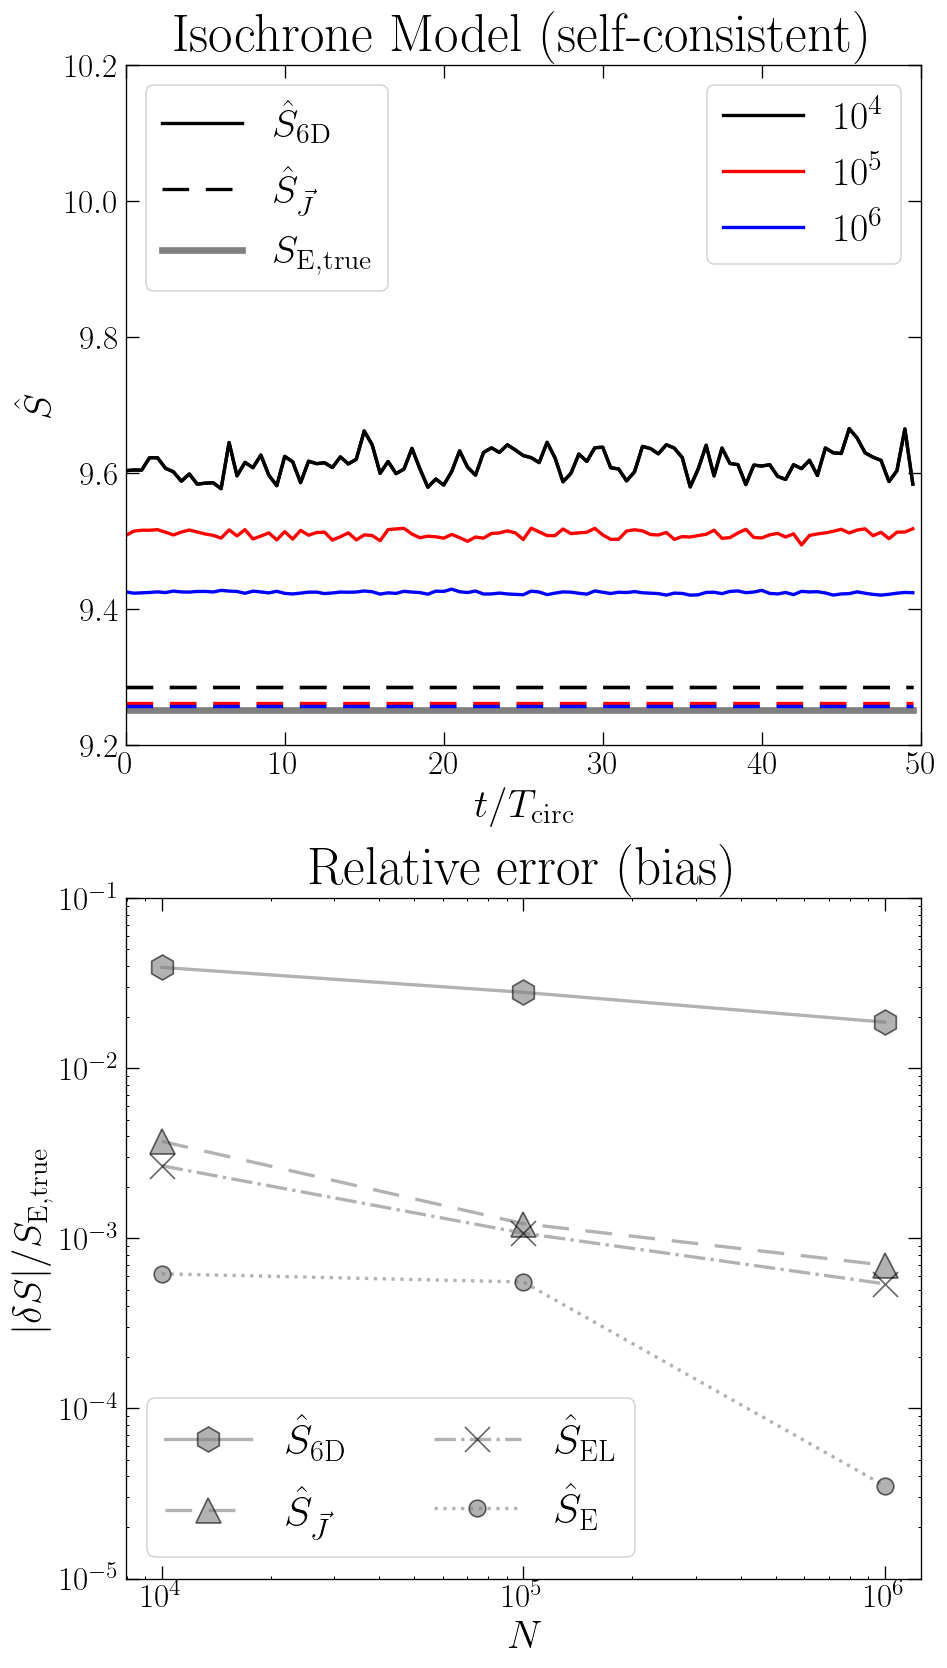

In [8]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(8,14))
fig.patch.set_facecolor('white')

axs[0].set_title('Isochrone Model (self-consistent)')
axs[1].set_title('Relative error (bias)')

ones = np.ones(n_steps)

for i in range(len(n_orbs)):
    axs[0].plot(t[i]/Tcirc[i], S_6D[i], ls='-', lw=2, c=N_colors[i], label=N_label_plot[i]) # Assumption-free estimate
    #axs[0].plot(t[i]/Tcirc[i], S_E[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i]) # Assuming the DF is an unknown f = f(E)
    #axs[0].plot(t[i]/Tcirc[i], S_EL[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i]) # Assuming the DF is an unknown f = f(E,L)
    axs[0].plot(t[i]/Tcirc[i], S_J[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i]) # Assuming the DF is an unknown f = f(J)

# To have two legends:
l1 = axs[0].legend(fontsize=24)

p1, = axs[0].plot(t[0]/Tcirc[0], S_6D[0], ls='-', lw=2, c=N_colors[0])
p2, = axs[0].plot(t[0]/Tcirc[0], S_J[0]*ones, color=N_colors[0], linestyle='--', dashes=(8,5), lw=2)
p3, = axs[0].plot(t[-1]/Tcirc[-1], S_E_true[-1]*ones, color='grey', linestyle='-', lw=4, zorder=0)
axs[0].legend([p1, p2, p3], [r'$\hat{S}_\mathrm{6D}$', r'$\hat{S}_{\vec{J}}$', r'$S_{\mathrm{E, true}}$'],
              loc='upper left', fontsize=24)
# Add l1 as a separate artist to the axes
axs[0].add_artist(l1)
#----------------
axs[1].plot(n_orbs, np.abs(err_S_6D),'h-',c='grey', ms=15, lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_\mathrm{6D}$')
axs[1].plot(n_orbs, np.abs(err_S_J), '^--', c='grey', ms=15, dashes=(8,5), lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_{\vec{J}}$')
axs[1].plot(n_orbs, np.abs(err_S_EL), 'x-.', c='grey', ms=15, lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_\mathrm{EL}$')
axs[1].plot(n_orbs, np.abs(err_S_E), '.:', c='grey', ms=20, lw=2, mec='black', alpha=0.6, label=r'$\hat{S}_\mathrm{E}$')

axs[1].legend(fontsize=26, loc='lower left', ncol=2)
#---------------------
axs[0].set_xlabel(r'$t/T_\mathrm{circ}$')
axs[0].set_ylabel(r'$\hat{S}$')
axs[0].set_ylim(9.2,10.2)
axs[0].set_xlim(0, 50)
    
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[1].set_xlabel(r'$N$')
axs[1].set_ylim(1e-5,1e-1)
axs[1].set_ylabel(r'$|\delta S|/S_{\mathrm{E, true}}$')

plt.tight_layout()

## Evolve initial sample in new potential

In [9]:
M_new = 3. # mass of new potential (where we integrate orbits for a non-stationary sample)

Now we generate the same initial sample, self-consistent with the isochrone potential of $M=1$, but evolve the sample in an isochrone potential with mass M = 3.

After the sample phase-mixes, it will be described by a DF $f = f(E,L)$, or $f = f(J)$, but we can't assume $f = f(E)$ for the final sample, since this is anisotropic in the velocities. Since the final $f(E,L)$ is unknown, we don't know the exact final entropy, but this can be assumed to be $\hat{S}_\mathrm{EL}$ for the largest sample, since we showed above that $\hat{S}_\mathrm{EL}$ is only biased by less than $0.1\%$.

In [10]:
# Set params and initialize arrays:

Tcirc_new = np.full(len(n_orbs), np.nan) # mean circular period for each sample
t_new = np.full((len(n_orbs), n_steps), np.nan) # time in the orbit integration
S_6D_new = np.full((len(n_orbs), n_steps), np.nan) # Entropy evaluated in 6D

# Entropies assuming the DF is f = f(E,L), or f = f(J) - now only expected to be valid after the system phase-mixes
# These should be the same as S_6D if f = f(E,L), or f = f(J). In the current case, this happens at the late times only.

S_EL_new = np.full(len(n_orbs), np.nan)
S_J_new = np.full(len(n_orbs), np.nan)

# new Potential:
isoc_pot_new = agama.Potential(type='Isochrone', mass=M_new, scaleRadius=b)
# Action finder in the new potential:
actF_new = agama.ActionFinder(isoc_pot_new)

In [11]:
# Same as before, but generating a sample stationary in the potential with mass M=1, and evolving it in a potential with mass M=3.
# Generate samples, integrate and estimate entropy:
for i in range(len(n_orbs)):
    print ('-------------------------')
    dim = 6
    print ('Generating sample...')
    N = n_orbs[i]
    data,_ = agama.GalaxyModel(isoc_pot, isoc_df).sample(N)
    # data, _ = isoc_pot.sample(N, potential=isoc_pot) 
    sigma_6D_0 = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in data.T])
    #------------------------------ 
    # Estimate S_6D (at t=0; estimates over time are done below):

    S_6D_new[i, 0] = tropygal.entropy(data/sigma_6D_0)
    print ('S_6D estimated:', np.round(S_6D_new[i, 0], 5))
    #------------------
    # Estimate S_EL, i.e. assuming f = f(E,L):

    x  = data[:,0]; y  = data[:,1]; z  = data[:,2]
    vx = data[:,3]; vy = data[:,4]; vz = data[:,5]
    
    v2 = vx**2 + vy**2 + vz**2
    pos = np.column_stack((x, y, z))
    E = isoc_pot_new.potential(pos) + 0.5*v2
    sigma_E = 0.5*(np.percentile(E, 84) - np.percentile(E, 16))
    
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2)
    EL = np.column_stack((E, L))
    sigma_L = 0.5*(np.percentile(L, 84) - np.percentile(L, 16))
    sigma_EL = np.array([sigma_E, sigma_L])

    g_EL = tropygal.gEL_Isochrone(E, L, M_new, G=G)
    # It's convenient to normalize coordinates in the space where the entropy is estimated,
    # but we want to stick to the entropy definition we used before, so the normalized coordinates are passed as the data,
    # and mu takes care of the appropriate factors in the change of variables for the integral defining the entropy to be the same:
    S_EL_new[i] = tropygal.entropy(EL/sigma_EL, mu= g_EL*np.prod(sigma_EL)/np.prod(sigma_6D_0))
    print ('S_EL estimated:', np.round(S_EL_new[i], 5))
    #------------------------------ 
    # Estimate S_J, i.e. assuming f = f(J):

    J = actF_new(data, actions=True, frequencies=False, angles=False)
    sigma_J = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in J.T])

    S_J_new[i] = tropygal.entropy(J/sigma_J, mu= ((2.*np.pi)**3)*np.prod(sigma_J)/np.prod(sigma_6D_0))
    print ('S_J estimated:', np.round(S_J_new[i],5))
    #------------------------------ 
    # Estimate S_6D at different times

    # define integration time (same for all orbits):
    Tcirc_new[i] = np.median(isoc_pot_new.Tcirc(data))
    int_time = 50*Tcirc_new[i]
    delta_t = int_time/n_steps
    t_new[i, 0] = 0

    for j in range(1, n_steps):
        # Integrate orbits for one time-step:
        orbs = agama.orbit(potential=isoc_pot_new, ic = data, time = delta_t, trajsize =1, verbose=False)

        t_new[i, j] = t_new[i, j-1] + delta_t
        all_coords = np.vstack(orbs[:,1]).reshape(len(x), 1, dim)
        # update data with new coords:
        data = all_coords[:,-1,:]

        sigma_6D = np.array([0.5*(np.percentile(coord, 84) - np.percentile(coord, 16)) for coord in data.T])
        # Here we re-normalize again at every time-step (to facilitate the estimate), 
        # "compensating" for that in the mu factor, i.e. making an appropriate change of variables every time-step:
        S_6D_new[i,j] = tropygal.entropy(data/sigma_6D, mu=np.prod(sigma_6D)/np.prod(sigma_6D_0))
        if (j%10==0):
            print ('j:', j, 'S_6D estimated:', np.round(S_6D_new[i, j], 5))

-------------------------
Generating sample...
S_6D estimated: 9.67761
S_EL estimated: 9.8514
S_J estimated: 9.86915
j: 10 S_6D estimated: 10.26609
j: 20 S_6D estimated: 10.24512
j: 30 S_6D estimated: 10.23972
j: 40 S_6D estimated: 10.2883
j: 50 S_6D estimated: 10.24338
j: 60 S_6D estimated: 10.23665
j: 70 S_6D estimated: 10.2692
j: 80 S_6D estimated: 10.24775
j: 90 S_6D estimated: 10.25597
-------------------------
Generating sample...
S_6D estimated: 9.50951
S_EL estimated: 9.81312
S_J estimated: 9.82143
j: 10 S_6D estimated: 10.08784
j: 20 S_6D estimated: 10.09876
j: 30 S_6D estimated: 10.10153
j: 40 S_6D estimated: 10.0955
j: 50 S_6D estimated: 10.08785
j: 60 S_6D estimated: 10.08601
j: 70 S_6D estimated: 10.08546
j: 80 S_6D estimated: 10.07536
j: 90 S_6D estimated: 10.09557
-------------------------
Generating sample...
S_6D estimated: 9.42018
S_EL estimated: 9.80942
S_J estimated: 9.8111
j: 10 S_6D estimated: 9.95121
j: 20 S_6D estimated: 9.99097
j: 30 S_6D estimated: 9.99648
j: 

## Plot

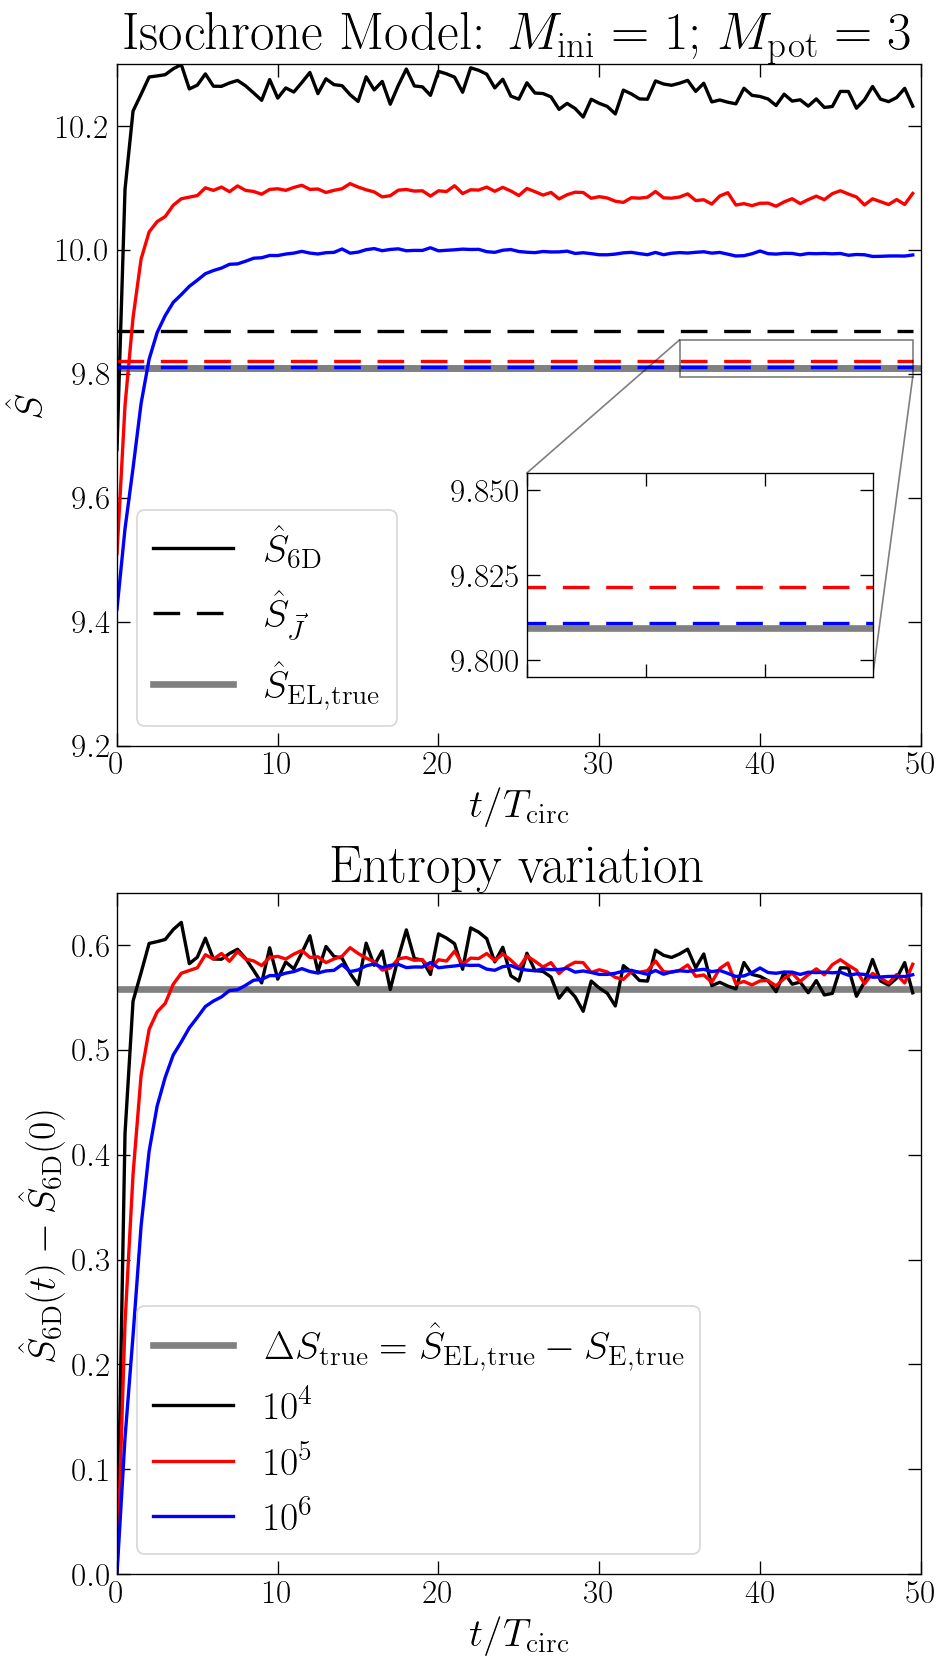

In [12]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(8,14))
fig.patch.set_facecolor('white')
axs[0].set_title(r'Isochrone Model: $M_\mathrm{ini}=1$; $M_\mathrm{pot}=3$')
axs[1].set_title('Entropy variation')

ones = np.ones(n_steps)
axs[0].axhline(y=S_EL_new[-1], color='grey', linestyle='-', lw=4, zorder=0)#, label=r'$S_{EL}$')

for i in range(len(n_orbs)):
    axs[0].plot(t_new[i]/Tcirc_new[i], S_6D_new[i], ls='-', lw=2, c=N_colors[i])
    axs[0].plot(t_new[i]/Tcirc_new[i], S_J_new[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i])

p4, = axs[0].plot(t_new[-1]/Tcirc_new[-1], S_EL_new[-1]*ones, color='grey', ls='-', lw=4, zorder=0)

axs[0].legend([p1, p2, p4], [r'$\hat{S}_\mathrm{6D}$', r'$\hat{S}_{\vec{J}}$', r'$\hat{S}_{\mathrm{EL, true}}$'], 
              loc = 'lower left', fontsize=24)
#---------------------
# inset axes:
x1, x2, y1, y2 = 35, 49.5, 9.795, 9.855  # subregion of the original image
axins = axs[0].inset_axes([0.51, 0.1, 0.43, 0.3],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[])#, yticklabels=[])
axins.axhline(y=S_EL_new[-1], color='grey', linestyle='-', lw=4, zorder=0)
for i in range(len(n_orbs)):
    axins.plot(t_new[i]/Tcirc_new[i], S_J_new[i]*ones, ls='--', dashes=(8,5), lw=2, c=N_colors[i])

axs[0].indicate_inset_zoom(axins, edgecolor="black")
#---------------------
# We take the final S_EL (estimated with the largest sample) as the true final S_EL:
axs[1].axhline(y=S_EL_new[-1] - S_E_true[-1], 
               color='grey', linestyle='-', lw=4, label=r'$\Delta S_\mathrm{true} = \hat{S}_{\mathrm{EL, true}} - S_{\mathrm{E, true}}$')

for i in range(len(n_orbs)):
    axs[1].plot(t_new[i]/Tcirc_new[i], S_6D_new[i]-S_6D_new[i, 0], ls='-', lw=2, c=N_colors[i], label=N_label_plot[i]) # Plotting Delta S

axs[0].set_ylabel(r'$\hat{S}$')
axs[0].set_ylim(9.2, 10.3)
axs[1].set_ylabel(r'$\hat{S}_\mathrm{6D}(t) - \hat{S}_\mathrm{6D}(0)$')
axs[1].set_ylim(0, 0.65)
axs[1].legend(fontsize=24)

for i in range(2):
    axs[i].set_xlim(0, 50)
    axs[i].set_xlabel(r'$t/T_\mathrm{circ}$')

plt.tight_layout()

We conclude that the entropy estimate in 6D is biased by a few percent both in respect to the true initial value (as demonstrated in the plot for the self-consistent sample), and in respect to the true final value $S_\mathrm{EL, true}$. This bias is nearly canceled by calculating entropy variations.

Besides that, not surprisingly the entropy estimates in lower dimensions, i.e. in the space of integrals, are much less biased.